### Import libraries

In [15]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from arch import arch_model
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timezone
from scipy.stats import beta, linregress
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import time
from tqdm import tqdm
import os
import glob

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {DEVICE}")
if DEVICE.type == "cuda":
    print(f"GPU Name; {torch.cuda.get_device_name(0)}")

Using Device: cpu


### Data Preparation Function

In [7]:
def download_btc_data(start_year, end_year, timeframe, symbol = 'BTC/USDT'):
    """
    Args:
        start_year (int): 시작 연도
        end_year (int): 종료 연도
        timeframe (str): 데이터 간격 ('1m', '10m' ,'1d')
        symbol (str): 코인 심볼 (기본 BTC/USDT)
    """
    
    save_dir = "data"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"[INFO] Directory '{save_dir}' created")

    # Create Binance object
    binance = ccxt.binance({
        'enableRateLimit': True,
        'options': {'defaultType': 'future'}
    })

    # Check wheather Binance support timeframe
    if timeframe not in binance.timeframes:
        print(f"[ERROR] '{timeframe} is not a valid timeframe")
        return

    print(f"Target: {symbol} | Timeframe: {timeframe} | Period: {start_year} ~ {end_year}")
    
    safe_symbol = symbol.replace("/", "")

    for year in range(start_year, end_year + 1):
        # Set file path including data folder
        filename = f"{safe_symbol}_{timeframe}_{year}.csv"
        file_path = os.path.join(save_dir, filename)
        
        # Check file existence
        if os.path.exists(file_path):
            print(f"[SKIP] '{filename}' already exists")
            continue
        
        print(f"\n[INFO] Downloading Year: {year}")
        start_date = datetime(year, 1, 1, 0, 0, 0, tzinfo = timezone.utc)
        end_date = datetime(year + 1, 1, 1, 0, 0, 0, tzinfo = timezone.utc)

        since = int(start_date.timestamp() * 1000)
        end_timestamp = int(end_date.timestamp() * 1000)

        year_ohlcvs = []

        approx_counts = {
            '1m': 525600, '1d': 365 # 10m Data Not Support in Binance API
        }
        total_candles = approx_counts.get(timeframe, 10000)

        pbar = tqdm(total = total_candles, desc = f"{year} Progress", unit = "candle")

        while since < end_timestamp:
            try:
                ohlcvs = binance.fetch_ohlcv(symbol, timeframe = timeframe, since = since, limit = 1000)

                if not ohlcvs:
                    break

                year_ohlcvs.extend(ohlcvs)

                current_last_time = ohlcvs[-1][0]
                since = current_last_time + 1

                pbar.update(len(ohlcvs))

                if current_last_time >= end_timestamp:
                    break

                time.sleep(0.05)

            except Exception as e:
                print(f"[ERROR] {e}, Retryung")
                time.sleep(3)
                continue

        pbar.close()

        if year_ohlcvs:
            df = pd.DataFrame(year_ohlcvs, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['datetime'] = pd.to_datetime(df['timestamp'], unit = 'ms', utc = True)

            df = df[(df['datetime'] >= start_date) & (df['datetime'] < end_date)]

            df.set_index('datetime', inplace = True)
            df.drop(columns = ['timestamp'], inplace = True)
            
            df.to_csv(file_path)
            print(f"[SUCCESS] Saved {file_path} (Rows: {len(df)})")
        else:
            print(f"[FAIL] No data for {year}")
            
            
def resample_to_10m(start_year, end_year, symbol = 'BTC/USDT'):
    """
    Transform 1m data to 10m data and store to csv file
    """
    save_dir = "data"
    safe_symbol = symbol.replace("/", "")
    
    print(f"Starting Resampling: {symbol} (1m -> 10m) | {start_year} ~ {end_year}")
    
    for year in range(start_year, end_year + 1):
        input_filename = f"{safe_symbol}_1m_{year}.csv"
        input_path = os.path.join(save_dir, input_filename)
        
        output_filename = f"{safe_symbol}_10m_{year}.csv"
        output_path = os.path.join(save_dir, output_filename)
        
        if not os.path.exists(input_path):
            print(f"[SKIP] Source file not found: {input_filename}")
            continue
        
        if os.path.exists(output_path):
            print(f"[SKIP] Target file already exists: {output_filename}")
            continue
        
        print(f"\n[PROCESSING] {input_filename} -> {output_filename}")
        
        try:
            df = pd.read_csv(input_path)
            df['datetime'] = pd.to_datetime(df['datetime'])
            df.set_index('datetime', inplace = True)
            
            ohlcv_dict = {
                'open': 'first',
                'high': 'max',
                'low': 'min',
                'close': 'last',
                'volume': 'sum'
            }
            
            df_10m = df.resample('10min').apply(ohlcv_dict)
            
            df_10m.dropna(inplace = True)
            
            df_10m.to_csv(output_path)
            print(f"[DONE] Saved {output_filename} (Rows: {len(df_10m)})")
            
        except Exception as e:
            print(f"[ERROR] Failed to process {year}: {e}")

In [8]:
# Prepare BTC Data for 1m, 1d, 10m
download_btc_data(2020, 2024, timeframe = '1m')
download_btc_data(2020, 2024, timeframe = '1d')
resample_to_10m(2020, 2024)

Target: BTC/USDT | Timeframe: 1m | Period: 2020 ~ 2024
[SKIP] 'BTCUSDT_1m_2020.csv' already exists
[SKIP] 'BTCUSDT_1m_2021.csv' already exists
[SKIP] 'BTCUSDT_1m_2022.csv' already exists
[SKIP] 'BTCUSDT_1m_2023.csv' already exists
[SKIP] 'BTCUSDT_1m_2024.csv' already exists
Target: BTC/USDT | Timeframe: 1d | Period: 2020 ~ 2024
[SKIP] 'BTCUSDT_1d_2020.csv' already exists
[SKIP] 'BTCUSDT_1d_2021.csv' already exists
[SKIP] 'BTCUSDT_1d_2022.csv' already exists
[SKIP] 'BTCUSDT_1d_2023.csv' already exists
[SKIP] 'BTCUSDT_1d_2024.csv' already exists
Starting Resampling: BTC/USDT (1m -> 10m) | 2020 ~ 2024
[SKIP] Target file already exists: BTCUSDT_10m_2020.csv
[SKIP] Target file already exists: BTCUSDT_10m_2021.csv
[SKIP] Target file already exists: BTCUSDT_10m_2022.csv
[SKIP] Target file already exists: BTCUSDT_10m_2023.csv
[SKIP] Target file already exists: BTCUSDT_10m_2024.csv


### MF-DFA Function

In [19]:
def mfdfa(batch_data, scales, q_list, device, poly_order = 1):
    """
    Fuction for MFDFA by using Pytorch

    Args:
        batch_data: (Batch_Size, Window_Size) tensor
    """
    
    batch_size, N = batch_data.shape
    
    profile = torch.cumsum(batch_data - batch_data.mean(dim = 1, keepdim = True), dim = 1)
    
    F_q_s = []
    valid_scales = []
    
    for s in scales:
        if N // s < 4: continue
        valid_scales.append(s)
        
        N_s = N // s
        seg_f = profile[:, :N_s*s].view(batch_size, N_s, s)
        
        seg_b = profile[:, -N_s*s:].view(batch_size, N_s, s)
        
        segments = torch.cat([seg_f, seg_b], dim = 1)
        
        x_axis = torch.arange(s, dtype = torch.float32, device = device)
        X_design = torch.stack([x_axis**i for i in range(poly_order + 1)], dim = 1)
        
        pinv_X = torch.linalg.pinv(X_design)

        beta = torch.matmul(segments, pinv_X.t())
        
        trend = torch.matmul(beta, X_design.t())
        
        resid = segments - trend
        F2 = torch.mean(resid**2, dim = 2)
        
        F2 = torch.clamp(F2, min = 1e-10)
        
        F_vals = []
        for q in q_list:
            if abs(q) < 1e-5:
                f_q = torch.exp(0.5 * torch.mean(torch.log(F2), dim = 1))
            else:
                f_q = torch.mean(F2**(q/2), dim = 1)**(1/q)
            F_vals.append(f_q)
            
        F_q_s.append(torch.stack(F_vals, dim = 1))
        
    if not F_q_s: return None, None
    
    F_q_s_tensor = torch.stack(F_q_s, dim = 1).permute(0, 2, 1)
    return np.array(valid_scales), F_q_s_tensor

def mfdfa_features(price_series, device, window, step):
    print(f"[INFO] Extracting MFDFA Features (Window: {window})")
    
    log_ret = np.log(price_series / price_series.shift(1)).dropna()
    values = log_ret.values
    
    windows = []
    indices = []
    
    BATCH_SIZE = 512
    features_list = []
    
    q_list = np.linspace(-5, 5, 15)
    scales = np.unique(np.logspace(np.log10(10), np.log10(window//4), 10).astype(int))
    
    for t in tqdm(range(window, len(values), step)):
        seg = values[t-window : t]
        windows.append(seg)
        indices.append(log_ret.index[t])
        
        if len(windows) >= BATCH_SIZE:
            batch_tensor = torch.tensor(np.array(windows), dtype = torch.float32).to(device)
            s_vals, F_tensor = mfdfa(batch_tensor, scales, q_list, device,)
            
            if F_tensor is not None:
                F_np = F_tensor.cpu().numpy()
                log_s = np.log(s_vals)
                
                for i in range(len(F_np)):
                    h_q = []
                    for i_q in range(len(q_list)):
                        slope, _, _, _, _ = linregress(log_s, np.log(F_np[i, i_q, :]))
                        h_q.append(slope)
                        
                    h_q = np.array(h_q)
                    delta_H = np.max(h_q) - np.min(h_q)
                    q_arr = np.array(q_list)
                    tau = q_arr * h_q - 1
                    alpha = np.gradient(tau, q_arr)
                    
                    delta_alpha = np.max(alpha) - np.min(alpha)
                    alpha_0 = alpha[len(q_list)//2]
                    
                    features_list.append([delta_H, delta_alpha, alpha_0])
                    
            windows = []
    if windows:
        batch_tensor = torch.tensor(np.array(windows), dtype = torch.float32).to(device)
        s_vals, F_tensor = mfdfa(batch_tensor, scales, q_list, device, poly_order = 1)
        if F_tensor is not None:
            F_np = F_tensor.cpu().numpy()
            log_s = np.log(s_vals)
            for i in range(len(F_np)):
                h_q = []
                for i_q in range(len(q_list)):
                    slope, _, _, _, _ = linregress(log_s, np.log(F_np[i, i_q, :]))
                    h_q.append(slope)
                h_q = np.array(h_q)
                delta_H = np.max(h_q) - np.min(h_q)
                q_arr = np.array(q_list)
                tau = q_arr * h_q - 1
                alpha = np.gradient(tau, q_arr)
                delta_alpha = np.max(alpha) - np.min(alpha)
                alpha_0 = alpha[len(q_list)//2]
                
                features_list.append([delta_H, delta_alpha, alpha_0])
    
    return pd.DataFrame(features_list, columns = ['delta_H', 'delta_alpha', 'alpha_0'], index = indices).dropna()


def compute_spectrum(price_series, device, q_list):
    log_ret = np.log(price_series / price_series.shift(1)).dropna()
    values = log_ret.values

    N = len(values)
    min_scale = 50
    max_scale = N // 10
    scales = np.unique(np.logspace(np.log10(min_scale), np.log10(max_scale), 30).astype(int))

    batch = torch.tensor(values.reshape(1, -1), dtype = torch.float32).to(device)
    s_vals, F_tensor = mfdfa(batch, scales, q_list, device)

    if F_tensor is None: return None

    F_np = F_tensor.cpu().numpy().squeeze(0)
    log_s = np.log(s_vals)
    h_q = []

    for i_q in range(len(q_list)):
        slope, _, _, _, _ = linregress(log_s, np.log(F_np[i_q, :]))
        h_q.append(slope)

    h_q = np.array(h_q)
    delta_H = np.max(h_q) - np.min(h_q)
    q_arr = np.array(q_list)
    tau = q_arr * h_q - 1
    alpha = np.gradient(tau, q_arr)
    delta_alpha = np.max(alpha) - np.min(alpha)
    f_alpha = q_arr * alpha - tau
    alpha_0 = alpha[len(q_list)//2]

    return{
        'scales': s_vals, 'F_q_s': F_np, 'H_q': h_q,
        'tau_q': tau, 'alpha': alpha, 'f_alpha': f_alpha,
        'delta_H': delta_H, 'delta_alpha': delta_alpha,
        'alpha_0': alpha_0
    }

### LSTM Model

In [10]:
class ResidualLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim = 64):
        super(ResidualLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first = True)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])
    
def prepare_lstm_data(base_df, mfdfa_df, lookback = 5):
    daily_stats = pd.DataFrame()
    daily_stats['Actual_RV'] = (base_df['return']**2).resample('1D').sum()
    daily_stats['GM_Var'] = (base_df['gm_vol']**2).resample('1D').sum()
    
    daily_stats['Actual_Vol'] = np.sqrt(daily_stats['Actual_RV'])
    daily_stats['GM_Vol'] = np.sqrt(daily_stats['GM_Var'])
    daily_stats['Residual'] = daily_stats['Actual_Vol'] - daily_stats['GM_Vol']
    if daily_stats.index.tz is not None:
        daily_stats.index = daily_stats.index.tz_localize(None)
    if mfdfa_df.index.tz is not None:
        mfdfa_df.index = mfdfa_df.index.tz_localize(None)
        
    daily_stats.index = daily_stats.index.normalize()
    mfdfa_df.index = mfdfa_df.index.normalize()
    
    data = pd.merge(daily_stats, mfdfa_df, left_index=True, right_index=True, how='inner').dropna()
    
    features_cols = ['Residual', 'Actual_Vol', 'delta_H', 'delta_alpha', 'alpha_0']
    
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    scaled_data = scaler_X.fit_transform(data[features_cols])
    scaled_target = scaler_y.fit_transform(data[['Residual']])
    
    X, y = [], []
    for i in range(len(scaled_data) - lookback):
        X.append(scaled_data[i : i + lookback])
        y.append(scaled_target[i+lookback])
        
    return np.array(X), np.array(y), scaler_y, data.index[lookback:], data

### GARCH-MIDAS Model

In [11]:
def get_beta_weights(K, w1, w2):
    k_vals = np.linspace(1e-6, 1.0 - 1e-6, K)
    weights = beta.pdf(k_vals, w1, w2)
    return weights / weights.sum()

def garch_midas(df_10m , daily_rv, midas_k = 22):
    print("[INFO] Running GARCH-MIDAS")
    weights = get_beta_weights(midas_k, 1.0, 5.0)
    daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
    daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
    
    df_combined = df_10m.join(daily_rv[['tau_pred']], on = df_10m.index.normalize())
    df_combined.dropna(subset = ['tau_pred', 'return'], inplace = True)
    
    df_combined['std_ret'] = df_combined['return'] / np.sqrt(df_combined['tau_pred'])
    
    am = arch_model(df_combined['std_ret'], vol = 'Garch', p = 1, q = 1)
    res = am.fit(disp = 'off')
    
    df_combined['g_t'] = res.conditional_volatility**2
    df_combined['gm_vol'] = np.sqrt(df_combined['tau_pred'] * df_combined['g_t'])
    
    return df_combined

Found 5 files
  -> Loaded 2020
  -> Loaded 2021
  -> Loaded 2022
  -> Loaded 2023
  -> Loaded 2024

 Running MFDFA
   -> Analyzed Merged (5 Years)
   -> Analyzed 2020
   -> Analyzed 2021
   -> Analyzed 2022
   -> Analyzed 2023
   -> Analyzed 2024


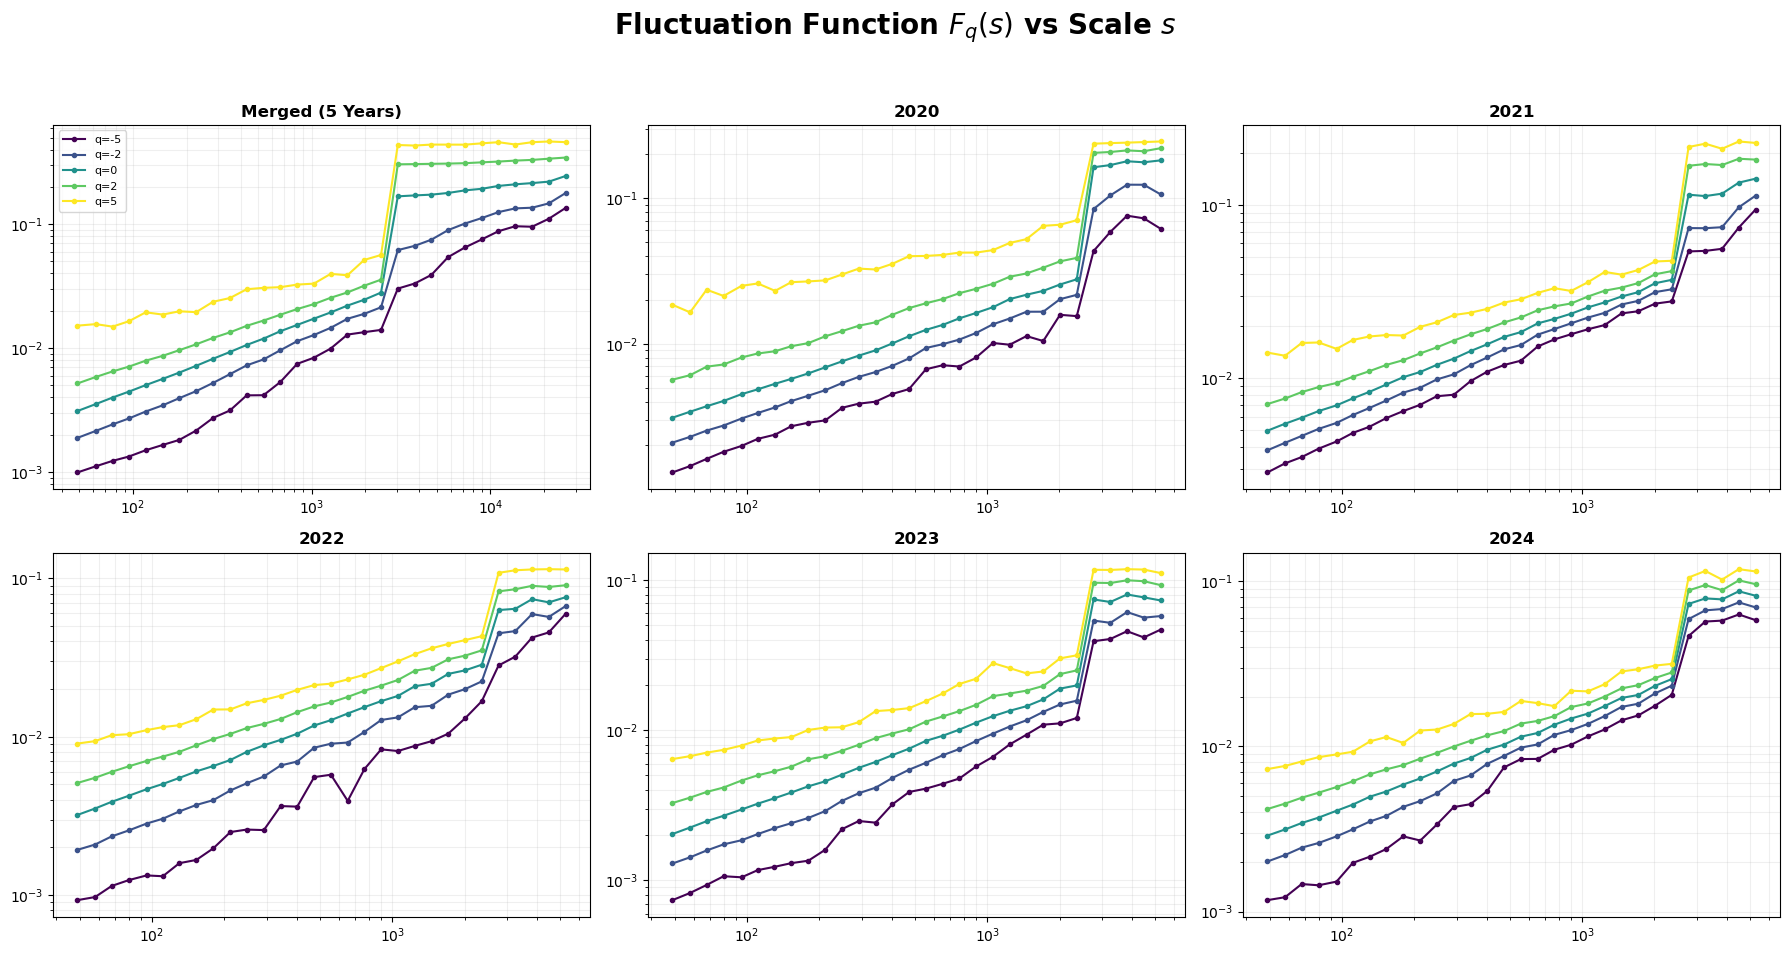

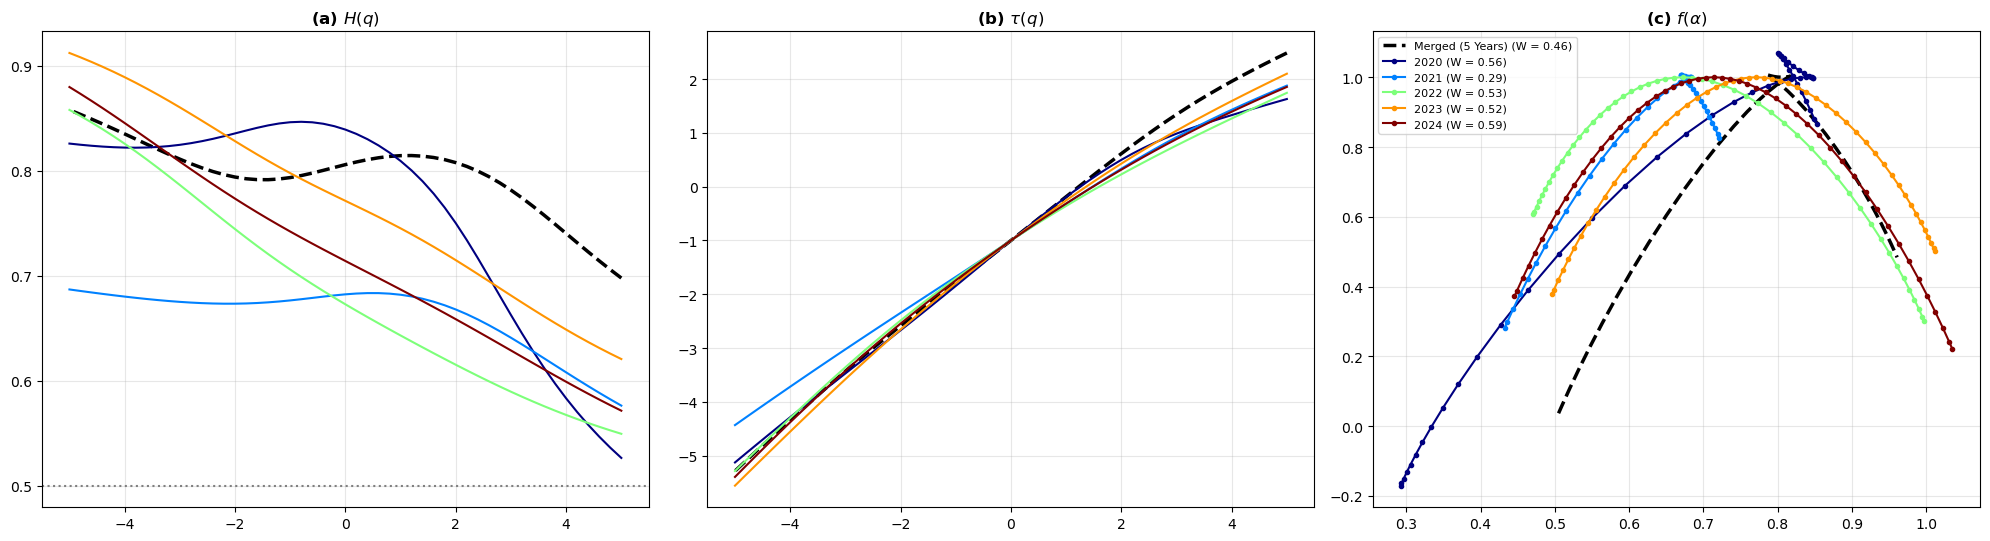

In [17]:
data_dir = "data"
files = sorted(glob.glob(os.path.join(data_dir, "BTCUSDT_10m_*.csv")))

if not files:
    print("No data")
else:
    print(f"Found {len(files)} files")

datasets = {}
df_list = []

for f in files:
    df = pd.read_csv(f, index_col = 'datetime', parse_dates = True)
    if 'return' not in df.columns:
        df['return'] = np.log(df['close']).diff()
    df.dropna(inplace = True)

    year = str(df.index.year[0])
    datasets[year] = df['close']
    df_list.append(df)
    print(f"  -> Loaded {year}")

df_all = pd.concat(df_list).sort_index()
datasets['Merged (5 Years)'] = df_all['close']

keys = sorted(list(datasets.keys()))
if 'Merged (5 Years)' in keys:
    keys.remove('Merged (5 Years)')
    keys.insert(0, 'Merged (5 Years)')

q_list = np.linspace(5, -5, 51)
results = {}

print("\n Running MFDFA")
for name in keys:
    res = compute_spectrum(datasets[name], DEVICE, q_list)
    if res: results[name] = res
    print(f"   -> Analyzed {name}")

fig1, axes1 = plt.subplots(2, 3, figsize = (18, 10))
fig1.suptitle('Fluctuation Function $F_q(s)$ vs Scale $s$', fontsize = 20, fontweight = 'bold')

q_plots = [-5, -2, 0, 2, 5]
colors_q = plt.cm.viridis(np.linspace(0, 1, len(q_plots)))

for i, ax in enumerate(axes1.flatten()):
    if i >= len(keys): ax.axis('off'); continue

    name = keys[i]
    res = results[name]
    for j, qv in enumerate(q_plots):
        idx = np.argmin(np.abs(q_list - qv))
        ax.loglog(res['scales'], res['F_q_s'][idx, :], 'o-', color = colors_q[j], ms = 3)

    ax.set_title(name, fontweight = 'bold')
    ax.grid(True, which = 'both', alpha = 0.2)
    if i == 0:
        handles = [mlines.Line2D([],[], color=colors_q[j], marker='o', ms=3, label=f'q={qv}') for j,qv in enumerate(q_plots)]
        ax.legend(handles = handles, fontsize = 8, loc = 'upper left')

plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()

fig2, axes2 = plt.subplots(1, 3, figsize = (20, 6))
year_keys = [k for k in keys if k != 'Merged (5 Years)']
cmap = plt.cm.jet(np.linspace(0, 1, len(year_keys)))
colors_y = {'Merged (5 Years)': 'black'}
for i, k in enumerate(year_keys): colors_y[k] = cmap[i]

titles = ['(a) $H(q)$', '(b) $ \\tau(q)$', '(c) $f(\\alpha)$']
for i, ax in enumerate(axes2):
    for name in keys:
        res = results[name]
        c = colors_y[name]
        style = '--' if 'Merged' in name else '-'
        lw = 2.5 if 'Merged' in name else 1.5

        if i == 0: ax.plot(q_list, res['H_q'], style, color = c, lw = lw, label = name)
        elif i == 1: ax.plot(q_list, res['tau_q'], style, color = c, lw = lw, label = name)
        elif i == 2:
            lbl = f"{name} (W = {res['delta_alpha']:.2f})"
            ax.plot(res['alpha'], res['f_alpha'], style if 'Merged' in name else 'o-', color=c, lw=lw, ms=3 if 'Merged' not in name else 0, label=lbl)

    ax.set_title(titles[i], fontweight = 'bold')
    ax.grid(True, alpha = 0.3)
    if i == 0: ax.axhline(0.5, c = 'gray', ls = ':')
    if i == 2: ax.legend(fontsize = 8)

plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()

Loading Datasets...
   -> Loaded 2020
   -> Loaded 2021
   -> Loaded 2022
   -> Loaded 2023
   -> Loaded 2024

START EXPERIMENT: 2020
   [Step 1] Extracting MFDFA Features (52703 rows)...
[INFO] Extracting MFDFA Features (Window: 4320)


100%|██████████| 336/336 [00:00<00:00, 321607.97it/s]


   [Step 2] Running GARCH-MIDAS...
[INFO] Running GARCH-MIDAS
   [Step 3] Preparing LSTM Data...
   [Step 4] Training LSTM (264 samples)...


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008512. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


   [Result] RMSE (GM): 0.4874 -> (Hybrid): 0.4383 | Improv: 10.07%


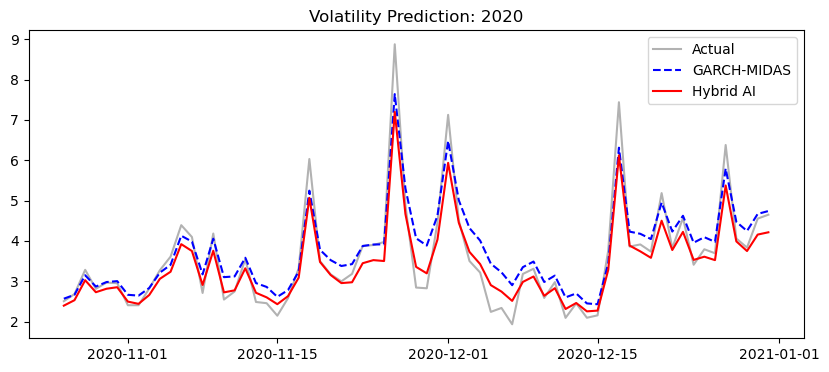


START EXPERIMENT: 2021
   [Step 1] Extracting MFDFA Features (52559 rows)...
[INFO] Extracting MFDFA Features (Window: 4320)


100%|██████████| 335/335 [00:00<00:00, 167852.33it/s]


   [Step 2] Running GARCH-MIDAS...
[INFO] Running GARCH-MIDAS
   [Step 3] Preparing LSTM Data...
   [Step 4] Training LSTM (264 samples)...


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008069. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


   [Result] RMSE (GM): 0.4980 -> (Hybrid): 0.4601 | Improv: 7.61%


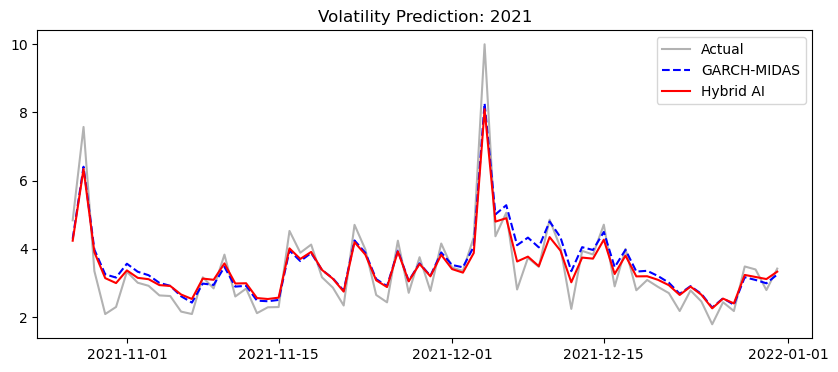


START EXPERIMENT: 2022
   [Step 1] Extracting MFDFA Features (52559 rows)...
[INFO] Extracting MFDFA Features (Window: 4320)


100%|██████████| 335/335 [00:00<00:00, 168314.79it/s]


   [Step 2] Running GARCH-MIDAS...
[INFO] Running GARCH-MIDAS
   [Step 3] Preparing LSTM Data...
   [Step 4] Training LSTM (264 samples)...


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007602. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


   [Result] RMSE (GM): 0.3488 -> (Hybrid): 0.2790 | Improv: 20.01%


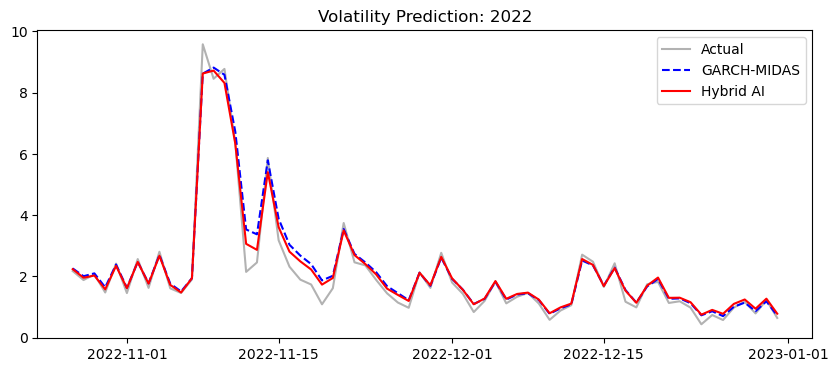


START EXPERIMENT: 2023
   [Step 1] Extracting MFDFA Features (52559 rows)...
[INFO] Extracting MFDFA Features (Window: 4320)


100%|██████████| 335/335 [00:00<00:00, 335104.18it/s]


   [Step 2] Running GARCH-MIDAS...
[INFO] Running GARCH-MIDAS
   [Step 3] Preparing LSTM Data...
   [Step 4] Training LSTM (264 samples)...


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008565. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


   [Result] RMSE (GM): 0.1194 -> (Hybrid): 0.1326 | Improv: -11.04%


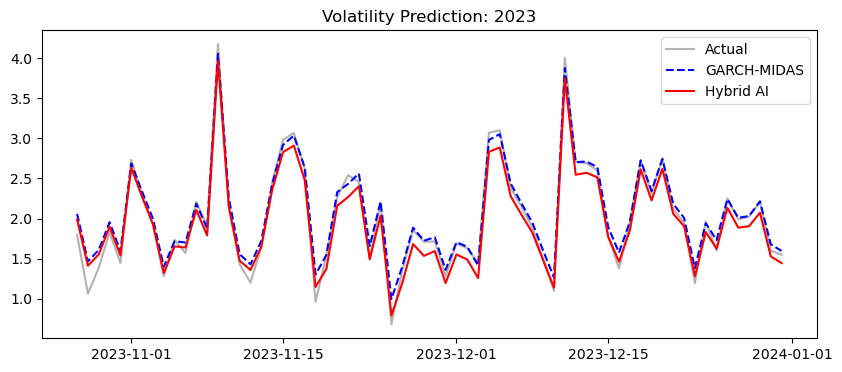


START EXPERIMENT: 2024
   [Step 1] Extracting MFDFA Features (52703 rows)...
[INFO] Extracting MFDFA Features (Window: 4320)


100%|██████████| 336/336 [00:00<00:00, 335544.32it/s]


   [Step 2] Running GARCH-MIDAS...
[INFO] Running GARCH-MIDAS
   [Step 3] Preparing LSTM Data...
   [Step 4] Training LSTM (264 samples)...


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007663. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


   [Result] RMSE (GM): 0.4190 -> (Hybrid): 0.3935 | Improv: 6.09%


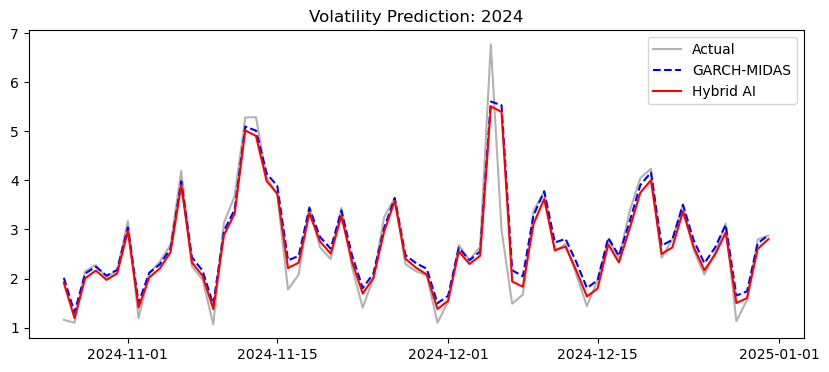


START EXPERIMENT: Merged (5 Years)
   [Step 1] Extracting MFDFA Features (263087 rows)...
[INFO] Extracting MFDFA Features (Window: 4320)


100%|██████████| 1797/1797 [00:01<00:00, 1034.36it/s]


   [Step 2] Running GARCH-MIDAS...
[INFO] Running GARCH-MIDAS


c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008219. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


   [Step 3] Preparing LSTM Data...
   [Step 4] Training LSTM (1433 samples)...
   [Result] RMSE (GM): 0.4417 -> (Hybrid): 0.3819 | Improv: 13.54%


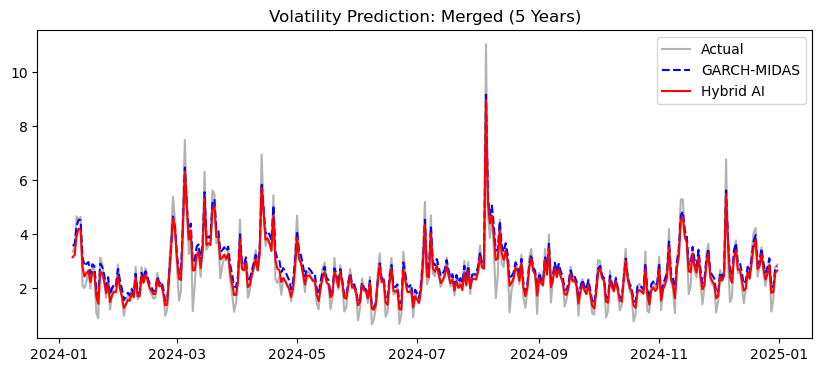


FINAL PERFORMANCE SUMMARY
         Dataset  RMSE_Base  RMSE_Hybrid  MAE_Hybrid  Improvement(%)
            2020     0.4874       0.4383      0.3044         10.0725
            2021     0.4980       0.4601      0.3493          7.6132
            2022     0.3488       0.2790      0.2013         20.0093
            2023     0.1194       0.1326      0.1138        -11.0357
            2024     0.4190       0.3935      0.2200          6.0886
Merged (5 Years)     0.4417       0.3819      0.2793         13.5351


In [20]:

def run_hybrid_experiment(name, df_data):
    print(f"\n{'='*60}")
    print(f"START EXPERIMENT: {name}")
    print(f"{'='*60}")
    
    if 'return' not in df_data.columns:
        df_data['return'] = np.log(df_data['close']).diff() * 100
    df_data.dropna(inplace=True)
    
    daily_rv = (df_data['return']**2).resample('1D').sum().to_frame('rv')
    
    candles_per_day = 144
    window_days = 30
    window_size = window_days * candles_per_day
    
    print(f"   [Step 1] Extracting MFDFA Features ({len(df_data)} rows)...")
    mfdfa_df = mfdfa_features(df_data['close'], DEVICE, window=window_size, step=candles_per_day)
    
    mfdfa_df.index = mfdfa_df.index.normalize()
    
    if len(mfdfa_df) == 0:
        print("   [Skip] MFDFA 결과 없음 (데이터 부족)")
        return None

    print("   [Step 2] Running GARCH-MIDAS...")
    df_gm = garch_midas(df_data, daily_rv)
    
    print("   [Step 3] Preparing LSTM Data...")
    try:
        X, y, scaler_y, dates, raw_data = prepare_lstm_data(df_gm, mfdfa_df, lookback=5)
    except ValueError as e:
        print(f"   [Skip] 데이터 병합 실패: {e}")
        return None
        
    split = int(len(X) * 0.8)
    X_train = torch.FloatTensor(X[:split]).to(DEVICE)
    y_train = torch.FloatTensor(y[:split]).to(DEVICE)
    X_test = torch.FloatTensor(X[split:]).to(DEVICE)
    
    print(f"   [Step 4] Training LSTM ({len(X_train)} samples)...")
    model = ResidualLSTM(input_dim=X.shape[2]).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    loss_fn = nn.MSELoss()
    
    EPOCHS = 150
    model.train()
    
    for epoch in range(EPOCHS):
        optimizer.zero_grad()
        pred = model(X_train)
        loss = loss_fn(pred, y_train)
        loss.backward()
        optimizer.step()
        
    model.eval()
    with torch.no_grad():
        pred_resid_scaled = model(X_test).cpu().numpy()
        
    pred_resid = scaler_y.inverse_transform(pred_resid_scaled)
    
    test_dates = dates[split:]
    final_df = pd.DataFrame(index=test_dates)
    final_df['Actual_Vol'] = raw_data.loc[test_dates, 'Actual_Vol']
    final_df['GM_Vol'] = raw_data.loc[test_dates, 'GM_Vol']
    final_df['Hybrid_Pred'] = final_df['GM_Vol'] + pred_resid.flatten()
    
    rmse_gm = np.sqrt(mean_squared_error(final_df['Actual_Vol'], final_df['GM_Vol']))
    rmse_hybrid = np.sqrt(mean_squared_error(final_df['Actual_Vol'], final_df['Hybrid_Pred']))
    mae_hybrid = mean_absolute_error(final_df['Actual_Vol'], final_df['Hybrid_Pred'])
    improvement = (rmse_gm - rmse_hybrid) / rmse_gm * 100
    
    print(f"   [Result] RMSE (GM): {rmse_gm:.4f} -> (Hybrid): {rmse_hybrid:.4f} | Improv: {improvement:.2f}%")
    
    plt.figure(figsize=(10, 4))
    plt.plot(final_df.index, final_df['Actual_Vol'], 'k-', alpha=0.3, label='Actual')
    plt.plot(final_df.index, final_df['GM_Vol'], 'b--', label='GARCH-MIDAS')
    plt.plot(final_df.index, final_df['Hybrid_Pred'], 'r-', label='Hybrid AI')
    plt.title(f"Volatility Prediction: {name}")
    plt.legend()
    plt.show()
    
    return {
        'Dataset': name,
        'RMSE_Base': rmse_gm,
        'RMSE_Hybrid': rmse_hybrid,
        'MAE_Hybrid': mae_hybrid,
        'Improvement(%)': improvement
    }


data_dir = "data"
files = sorted(glob.glob(os.path.join(data_dir, "BTCUSDT_10m_*.csv")))

if not files:
    print("데이터 파일이 없습니다.")
else:
    datasets = {}
    df_list = []
    
    print("Loading Datasets...")
    for f in files:
        df = pd.read_csv(f, index_col='datetime', parse_dates=True)
        year = str(df.index.year[0])
        datasets[year] = df
        df_list.append(df)
        print(f"   -> Loaded {year}")
        
    df_all = pd.concat(df_list).sort_index()
    datasets['Merged (5 Years)'] = df_all
    
    keys = sorted([k for k in datasets.keys() if 'Merged' not in k]) + ['Merged (5 Years)']
    
    summary_results = []
    
    for name in keys:
        df_target = datasets[name].copy()
        
        res = run_hybrid_experiment(name, df_target)
        if res:
            summary_results.append(res)
            
    print("\n" + "="*60)
    print("FINAL PERFORMANCE SUMMARY")
    print("="*60)
    summary_df = pd.DataFrame(summary_results)
    print(summary_df.to_string(index=False, float_format=lambda x: "{:.4f}".format(x)))
    print("="*60)